### Sumário

- Definindo o problema
- Combinando duas informações ruidosas
- Maximizando a função de verossimilhança numericamente
- Conclusão

### Definindo o problema

Nesta tópico vamos expandir o exemplo apresentado no tópico Se pesando em uma balança incerte com MLE adicionando mais uma variável ao problema, no caso, mais uma balança que dessa vez faz uma leitura pior que a primeira. 

Para começar, assim como no tópico citado, vamos definir as duas balancas. A primeira com 95% de chance não erra sua medida com mais de 0.5 kg do peso real. Já a segunda um pouco pior que a primeira, com 95 de chance não erra mais que 1 kg.

Vamos ver a pdf das duas balancas, chamadas aque de balança A e balança B.

In [112]:
import numpy as np
import matplotlib.pyplot as plt

In [113]:
weight_real = 70
weight_sigma_a = 0.5/1.96
weight_sigma_b = 1/1.96

In [114]:
def gaussian(x, mu, std):
    return np.exp(-0.5*((x-mu)/std)**2)/(std*np.sqrt(2*np.pi))

In [115]:
x = np.linspace(68, 72, 1000)
gauss_a = gaussian(x, weight_real, weight_sigma_a)
gauss_b = gaussian(x, weight_real, weight_sigma_b)

In [116]:
weight_samples = [np.random.normal(weight_real, weight_sigma_a, 1), \
                  np.random.normal(weight_real, weight_sigma_b, 1)]
weight_samples

[array([70.2151654]), array([70.1142273])]

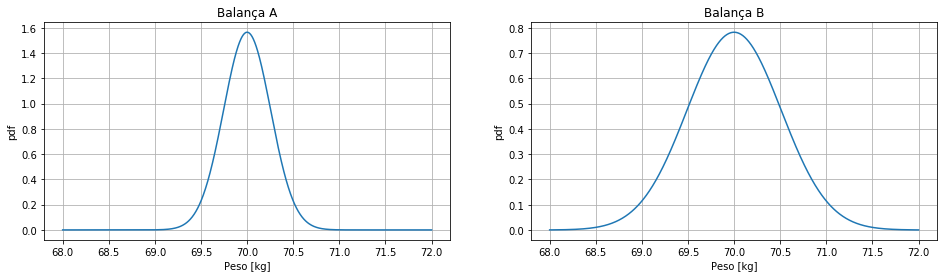

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(x, gauss_a)
axs[0].set_title("Balança A")
axs[0].set_ylabel("pdf")
axs[0].set_xlabel("Peso [kg]")
axs[0].grid()
axs[1].plot(x, gauss_b)
axs[1].set_title("Balança B")
axs[1].set_ylabel("pdf")
axs[1].set_xlabel("Peso [kg]")
axs[1].grid()

Vamos verificar a faixa de peso correspondente a 95% de probabilidade

In [118]:
from scipy.integrate import quad

In [119]:
quad(gaussian, 69.5, 70.5, args=(weight_real, weight_sigma_a))[0]

0.950004209703558

In [120]:
quad(gaussian, 69, 71, args=(weight_real, weight_sigma_b))[0]

0.9500042097035599

### Combinando duas informações ruidosas

Segue então algumas perguntas, o que fazer com os dois resultados obtidos?, Devemos escolher somente um deles?, Combinar os dois?, Se sim, como?.

Embora nosso objetivo seja estimar um número mais próximo possível ao peso real, a melhor ação a se tomar ainda não é clara. Para isso, vamos formalizar a noção de mais próximo possível do peso real.

Dadas as premissas assumidas de que a leitura se comporta como o processo de amostragem de um variável aleatória gaussiana cuja média é igual ao peso real, podemos dizer que estimar o valor mais próximo possível corresponde a estimar a média $\mu$ da pdf gaussia.

Ainda sim, não é claro como fazer isso, vamos então adicionar mais um objetivo a nossa missão, vamos procurar pelo valor de $\mu$ que máximiza a probabilidade de termos lidos os valores apresentados na balança.

Essa probabilidade, é dada pela função de verossimilhança:

$L(x_1, x_2; \mu, \sigma_1, \sigma_2) = \prod_{i=1}^{2}f(x_i/\mu,\sigma_1,\sigma_2) = \frac{1}{\sigma_1\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x_1 - \mu}{\sigma_1})^2}\frac{1}{\sigma_2\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x_2 - \mu}{\sigma_2})^2}$

Onde $x_1$ e $x_2$ são os valores lidos pelas balanças A e B, $\sigma_1$ = 0.255, $\sigma_2 = 0.510$ e $\mu$ é o parâmetro que queremos encontrar.

Vamos então ver qual o valor de $\mu$ que maximiza a função:

$\mu = \underset{\mu}{\operatorname{argmax}}L(x_1, x_2; \mu, \sigma) = \underset{\mu}{\operatorname{argmax}}logL(x_1, x_2; \mu, \sigma) = \underset{\mu}{\operatorname{argmax}}-\frac{1}{2}(\frac{x_1-\mu}{\sigma_1})^2 -\frac{1}{2}(\frac{x_2-\mu}{\sigma_1})^2= -\frac{(x_1-\mu)^2}{\sigma_1^2}-\frac{(x_2-\mu)^2}{\sigma_2^2}$

Neste caso, para maximizar a função basta derivar em relação a $\mu$ e igualar a 0 temos:

$\frac{\partial{L(x_1, x_2; \mu, \sigma)}}{\partial{\mu}} = 2\frac{(x_1-\mu)}{\sigma_1^2}+2\frac{(x_2-\mu)}{\sigma_2^2} = \frac{\sigma_2^2(x_1-\mu) + \sigma_1^2(x_2-\mu)}{\sigma_1^2\sigma_2^2}$ = 0

Com isso temos:

$\mu_{max} = \frac{x_1\sigma_2^2 + x_2\sigma_1^2}{\sigma_1^2+\sigma_2^2}$

Ou seja, segundo o critério MLE a estimativa do peso real é dada pela média ponderada dos valores medidos, sendo a ponderação data pelas variâncias das balanças. Um detalhe importante na solução final é que a balança mais imprecisa (balança B) tem um peso menor na estimativa final, o que é esperado, já que parece bastante sensato confiar menos na segunda balança.

### Maximizando a função de verossimilhança numericamente

Vamos verificar isso numericamente de três maneiras, a primeira é plotando a função de verossimilhança para uma faixa de valores de $\mu$ e encontrando o valor máximo.

In [27]:
mu_candidate = np.linspace(69.5, 70.5, 1000)

In [28]:
pdf_mu_sample1 = gaussian(weight_samples[0], mu_candidate, weight_sigma_a)
pdf_mu_sample2 = gaussian(weight_samples[1], mu_candidate, weight_sigma_b)
pdf_mu_sample = pdf_mu_sample1*pdf_mu_sample2

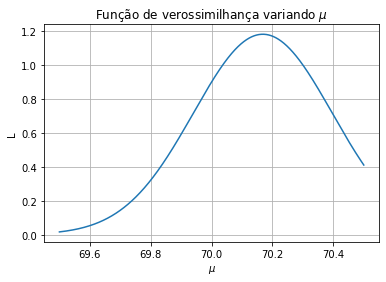

In [29]:
plt.plot(mu_candidate, pdf_mu_sample)
plt.title("Função de verossimilhança variando $\mu$")
plt.ylabel("L")
plt.xlabel("$\mu$")
plt.grid()

In [30]:
mu_candidate[np.argmax(pdf_mu_sample)]

70.16866866866867

A segunda é maximizando a função através de um algorítimo de otimização.

In [85]:
def two_gaussian(mu, x1, x2, std_a, std_b):
    return -1*np.exp(-0.5*((x1-mu)/std_a)**2)/(std_a*np.sqrt(2*np.pi))*\
           np.exp(-0.5*((x2-mu)/std_b)**2)/(std_b*np.sqrt(2*np.pi))

from scipy.optimize import minimize

minimize(two_gaussian, 70, args=(weight_samples[0], weight_samples[1], weight_sigma_a, weight_sigma_b))

      fun: -1.1790905434388415
 hess_inv: array([[0.04418884]])
      jac: array([-2.07126141e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([70.1682459])

In [110]:
weight_sigma = [weight_sigma_b**2, weight_sigma_a**2]
summ = sum(weight_sigma)
weight_sigma[0] = weight_sigma[0]/summ
weight_sigma[1] = weight_sigma[1]/summ

In [111]:
np.average(np.hstack(weight_samples), weights=weight_sigma)

70.16824600275928

### Conclusão

Neste tópico discutimos:

- O estimador de verossimilhança.
- Um exemplo com duas balanças com diferentes níveis de incerteza
- Como encontrar analiticamente o estimador MLE
- Como encontrar númericamente o estimador MLE